## Import Dependencies

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [2]:
# Import data
main_df = pd.read_csv('Forbes Richest Athletes (Forbes Richest Athletes 1990-2020).csv', index_col=0)
test = pd.read_csv('Forbes Top 10 Female Athletes 2021.csv', index_col=0)

# Join with original dataset for dummy feature creation
test = main_df.append(test)

# Create dummies
test_dummies_df = pd.get_dummies(test, columns=["Nationality","Sport"])

# Remove main_df data leaving just female data
test_dummies_df = test_dummies_df[-10:]

# Split the testing data
X_test = test_dummies_df.drop(columns=['Name','Gender','Earnings ($ million)'])
y_test = test_dummies_df['Earnings ($ million)']

In [3]:
# Get names of top 10 female athletes
names = test_dummies_df['Name']

## Functions

In [4]:
def mean(l):
    return sum(l)/len(l)

In [5]:
# Generate ensemble
def get_ensemble(file_suffix):
    
    # Import models
    rf_model = joblib.load(f'models/rf_model{file_suffix}.pkl')
    et_model = joblib.load(f'models/et_model{file_suffix}.pkl')
    xgb_model = joblib.load(f'models/xgb_model{file_suffix}.pkl')
    bag_model = joblib.load(f'models/bag_model{file_suffix}.pkl')
    dt_model = joblib.load(f'models/dt_model{file_suffix}.pkl')

    ensemble = [rf_model, et_model, xgb_model, bag_model, dt_model]
    
    return ensemble

In [6]:
# Get predictions from all models
def get_model_preds(ensemble):
    
    # Get all predictions for all athletes on all models
    y_preds = [list(model.predict(X_test)) for model in ensemble]
    
    # Average each athlete's predictions from all 5 models to get the final prediction
    y_ens_pred = [mean(preds) for preds in zip(*y_preds)]
    
    return y_ens_pred

In [22]:
# Generate the actual vs. predicted earnings plot
def gen_plot(df, subtitle):

    # Plot the actual vs. predicted earnings
    plt.figure(figsize=(7,7))
    sns.barplot(
        x='value',
        y='Athlete',
        hue='Earnings Type',
        data=df,
        orient='h'
    )
    
    # Format and label plot
    plt.legend(bbox_to_anchor=(1.4,1), fancybox=True, shadow=True)
    plt.suptitle('Actual vs. Predicted Earnings by Athlete')
    plt.title(subtitle)
    plt.xlabel('Earnings ($ million)')
    plt.show()

In [8]:
# Get melted df for plotting
def pred_actual_plot(preds, subtitle=""):
    
    # Create base Dataframe of each athlete's actual earnings
    earnings_df = pd.DataFrame({
        'Athlete': names,
        'Actual Earnings':y_test
    })
    
    if len(preds) == 1:
        earnings_df['Predicted Earnings'] = preds[0]
    else:
        earnings_df['Predicted Earnings (all male data)'] = preds[0]
        earnings_df['Predicted Earnings (training only)'] = preds[1]
    
    # "Melt" the df so each row is a different instance of earnings_type by athlete and the cooresponding value
    melted_df = pd.melt(earnings_df, id_vars='Athlete', var_name='Earnings Type')
    
    gen_plot(melted_df, subtitle)
    
    return earnings_df

## Test based on all data

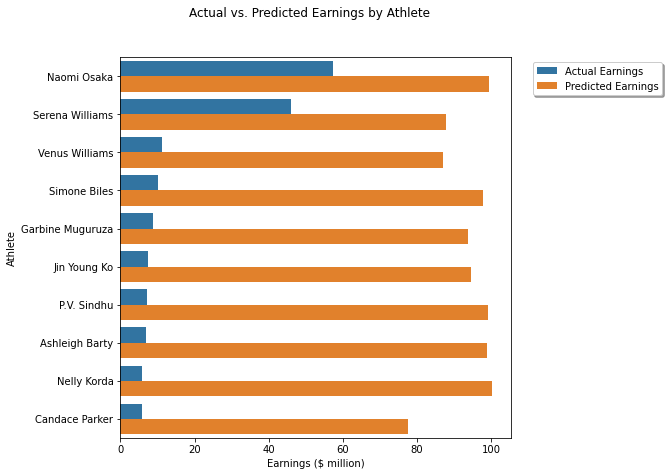

In [23]:
file_suffix = ""
ens = get_ensemble(file_suffix)
y_pred = get_model_preds(ens)
female_df = pred_actual_plot([y_pred], subtitle='')

## Test based on just training data

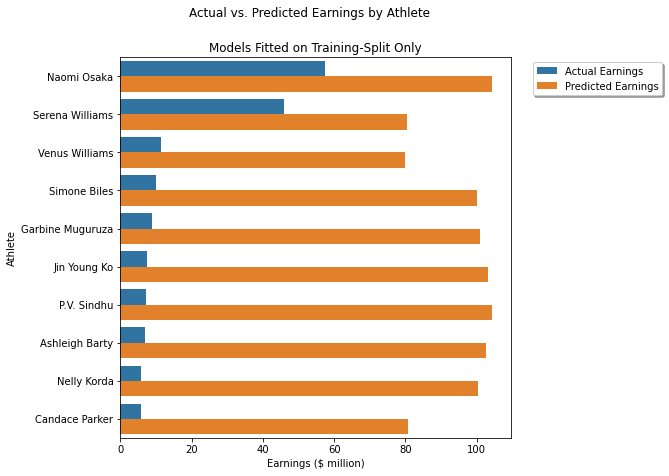

,Athlete,Actual Earnings,Predicted Earnings
S.NO,,,
1,Naomi Osaka,57.3,104.409369
2,Serena Williams,45.9,80.442494
3,Venus Williams,11.3,79.978046
4,Simone Biles,10.1,99.969934
5,Garbine Muguruza,8.8,100.938738
6,Jin Young Ko,7.5,103.074935
7,P.V. Sindhu,7.2,104.206602
8,Ashleigh Barty,6.9,102.569185
9,Nelly Korda,5.9,100.402070


In [10]:
file_suffix = "_train"
ens = get_ensemble(file_suffix)
y_pred = get_model_preds(ens)
pred_actual_plot([y_pred], subtitle='Models Fitted on Training-Split Only')

## Both Put Together

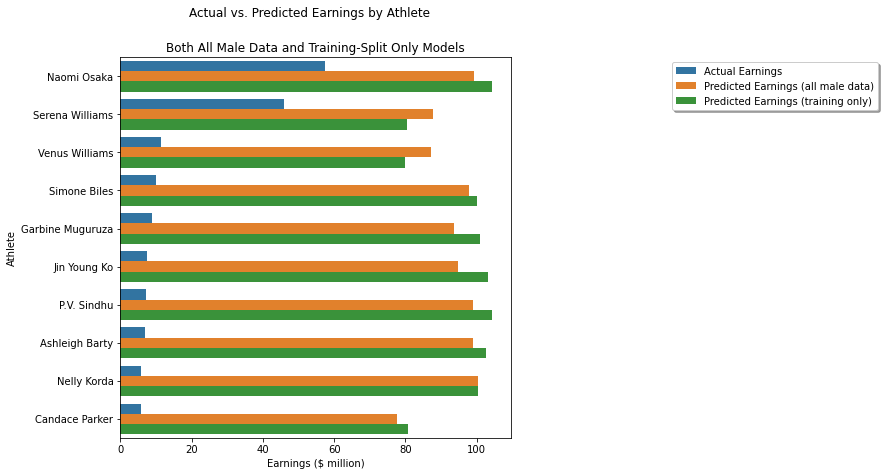

,Athlete,Actual Earnings,Predicted Earnings (all male data),Predicted Earnings (training only)
S.NO,,,,
1,Naomi Osaka,57.3,99.254826,104.409369
2,Serena Williams,45.9,87.735950,80.442494
3,Venus Williams,11.3,87.093652,79.978046
4,Simone Biles,10.1,97.811986,99.969934
5,Garbine Muguruza,8.8,93.757492,100.938738
6,Jin Young Ko,7.5,94.638590,103.074935
7,P.V. Sindhu,7.2,98.997719,104.206602
8,Ashleigh Barty,6.9,98.915439,102.569185
9,Nelly Korda,5.9,100.316723,100.402070


In [11]:
# Get ensembles
ens_train = get_ensemble('_train')
ens_all = get_ensemble('')

# Get predictions
y_pred_train = get_model_preds(ens_train)
y_pred_all = get_model_preds(ens_all)

# Get Plot
pred_actual_plot([y_pred_all, y_pred_train], subtitle='Both All Male Data and Training-Split Only Models')

In [12]:
female_df['Percent of Predicted'] = round(female_df['Actual Earnings']/female_df['Predicted Earnings']*100,1)
female_df['Variance'] = round((female_df['Predicted Earnings']-female_df['Actual Earnings'])/female_df['Predicted Earnings']*100,1)

In [13]:
female_df

,Athlete,Actual Earnings,Predicted Earnings,Percent of Predicted,Variance
S.NO,,,,,
1,Naomi Osaka,57.3,99.254826,57.7,42.3
2,Serena Williams,45.9,87.735950,52.3,47.7
3,Venus Williams,11.3,87.093652,13.0,87.0
4,Simone Biles,10.1,97.811986,10.3,89.7
5,Garbine Muguruza,8.8,93.757492,9.4,90.6
6,Jin Young Ko,7.5,94.638590,7.9,92.1
7,P.V. Sindhu,7.2,98.997719,7.3,92.7
8,Ashleigh Barty,6.9,98.915439,7.0,93.0
9,Nelly Korda,5.9,100.316723,5.9,94.1


In [14]:
mean(main_df.loc[main_df['Year']==2021,'Earnings ($ million)'])

105.2

In [15]:
mean(female_df['Predicted Earnings'])

93.61290033470517

In [16]:
mean(female_df['Actual Earnings'])

16.659999999999997

 ## Test Accuracy

In [17]:
pred = female_df['Predicted Earnings']
actual = female_df['Actual Earnings']

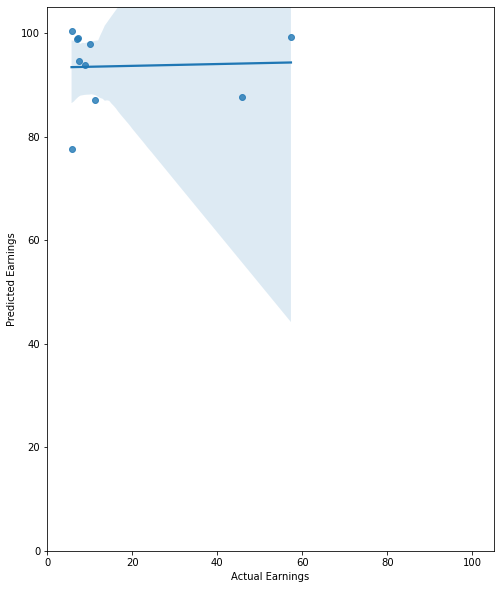

In [20]:
plt.figure(figsize=(8,10))
sns.regplot(actual,pred)
plt.xlim(0, 105)
plt.ylim(0, 105)
plt.show()

In [24]:
pred

S.NO
1      99.254826
2      87.735950
3      87.093652
4      97.811986
5      93.757492
6      94.638590
7      98.997719
8      98.915439
9     100.316723
10     77.606628
Name: Predicted Earnings, dtype: float64

In [25]:
actual

S.NO
1     57.3
2     45.9
3     11.3
4     10.1
5      8.8
6      7.5
7      7.2
8      6.9
9      5.9
10     5.7
Name: Actual Earnings, dtype: float64